# Image-to-image transition between pipelines

This notebook contains functions to compute metrics between samples generated by different image-to-image transition frameworks. 

In [1]:
from utils.datasets import ImageDataset
from utils import metrics
from torch.utils.data import DataLoader
from glob import glob
from scipy import stats
from statannotations.Annotator import Annotator
from utils import denorm
from models import classifier
from nilearn import plotting 
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

import sys 
import importlib
import torch
import os
import random

In [2]:
pipelines = ['fsl-5-0-0', 'fsl-5-0-1', 'spm-5-0-0', 'spm-5-0-1']

## Compute metrics

To compute metrics for a particular model: 
- change the variables model ('cc_ddpm', 'c_ddpm' or 'stargan'), 
- the sampling ('', '-kmeans', '-knn')
- and the n value (1, 5, 10, or 20). 

In [3]:
if not os.path.exists('./results/metrics'):
    os.mkdir('./results/metrics')

In [56]:
w = '_w0.5'
model = 'cc_ddpm'
sampling = '-knn'
n = '_n10'
sample_dir = f'./results/samples/{model}-samples'

In [50]:
# p_source_list = ['fsl-5-0-0', 'fsl-5-0-1', 'spm-5-0-0', 'spm-5-0-1']
p_target_list = ['fsl-5-0-0', 'fsl-5-0-1', 'spm-5-0-0', 'spm-5-0-1']

p_source_list = [0,1,2,3]
# p_target_list = [0,1,2,3]

### Correlations

In [89]:
print(model, sampling, 'w =', w, ', n =', n)

for i, p_source in enumerate(p_source_list):
    for j, p_target in enumerate(p_target_list):
        
        corr_st = []
        corr_tg = []
        corr_sg = []
    
        for img in range(i, 80, 4):

            if model not in ['vox2vox_l-mse', 'cycleGAN', 'stargan']:
        
                data_trg = sorted(
                    glob(
                        f'{sample_dir}/' + \
                        f'trg-image_{img}-dataset_rh_4classes-jeanzay_ep190_w{w}{n}-orig_{p_source}-target_{p_target}.nii.gz'
                    )
                )[0]
                
                data_gen = sorted(
                    glob(
                        f'{sample_dir}/' + \
                        f'gen-image_{img}-dataset_rh_4classes-jeanzay_ep190_w{w}{n}-orig_{p_source}-target_{p_target}.nii.gz'
                    )
                )[0]
                
                data_src = sorted(
                    glob(
                        f'{sample_dir}/' + \
                        f'src-image_{img}-dataset_rh_4classes-jeanzay_ep190_w{w}{n}-orig_{p_source}-target_{p_target}.nii.gz'
                    )
                )[0]

            else: 
                if model == 'stargan':
                    data_trg = sorted(
                        glob(
                            f'{sample_dir}/' + \
                            f'trg_img-{img}_orig_{p_source}-target_{p_target}.nii.gz'
                        )
                    )[0]
                    
                    data_gen = sorted(
                        glob(
                            f'{sample_dir}/' + \
                            f'gen_img-{img}_orig_{p_source}-target_{p_target}.nii.gz'
                        )
                    )[0]
                    
                    data_src = sorted(
                        glob(
                            f'{sample_dir}/' + \
                            f'src_img-{img}_orig_{p_source}-target_{p_target}.nii.gz'
                        )
                    )[0]
                else: 
                    if p_source != p_target:
                        data_trg = sorted(
                            glob(
                                f'{sample_dir}/{p_source}_to_{p_target}_b-16_lr-0.0001_e-190_model-{model}/' + \
                                f'trg-image-{img}_src-{p_source}_trg-{p_target}.nii.gz'
                            )
                        )[0]
                        
                        data_gen = sorted(
                            glob(
                                f'{sample_dir}/{p_source}_to_{p_target}_b-16_lr-0.0001_e-190_model-{model}/' + \
                                f'gen-image-{img}_src-{p_source}_trg-{p_target}.nii.gz'
                            )
                        )[0]
                        
                        data_src = sorted(
                            glob(
                                f'{sample_dir}/{p_source}_to_{p_target}_b-16_lr-0.0001_e-190_model-{model}/' + \
                                f'src-image-{img}_src-{p_source}_trg-{p_target}.nii.gz'
                            )
                        )[0]
                    else:
                        continue
            
    
            corr_sg.append(
                metrics.get_correlation(
                    nib.load(data_src), 
                    nib.load(data_gen)
                )
            )
            # Source - Target correlations
            corr_st.append(
                metrics.get_correlation(
                    nib.load(data_src), 
                    nib.load(data_trg)
                )
            )
        
            # Generated - Target correlations
            corr_tg.append(
                metrics.get_correlation(
                    nib.load(data_trg), 
                    nib.load(data_gen)
                )
            )
            
        df_st = pd.DataFrame(
            {'Type' :['Source-Target' for i in range(len(corr_st))],
             'Correlation' : corr_st}
        )
    
        df_sg = pd.DataFrame(
            {'Type' :['Source-Generated' for i in range(len(corr_sg))],
             'Correlation' : corr_sg}
        )
        
        df_tg = pd.DataFrame(
            {'Type' :['Target-Generated' for i in range(len(corr_tg))],
             'Correlation' : corr_tg}
        )
        
        df = pd.concat([df_st, df_tg, df_sg])
        
        df.to_csv(f'./results/metrics/correlations_{pipelines[i]}_{pipelines[j]}{w}{n}{sampling}-{model}.csv')
        print(f'{pipelines[i]}_{pipelines[j]}')
        print('Source-Target', round(np.mean(df['Correlation'].loc[df['Type']=='Source-Target'])*100,1))
        print('Target-Generated', round(np.mean(df['Correlation'].loc[df['Type']=='Target-Generated'])*100,1), 
              round(np.std(df['Correlation'].loc[df['Type']=='Target-Generated'])*100,1))

cycleGAN  w = 0.5 , n = 
fsl-5-0-0_fsl-5-0-0
Source-Target nan
Target-Generated nan nan
fsl-5-0-0_fsl-5-0-1
Source-Target 92.7
Target-Generated 60.5 2.0
fsl-5-0-0_spm-5-0-0
Source-Target 86.1
Target-Generated 84.6 1.7
fsl-5-0-0_spm-5-0-1
Source-Target 79.7
Target-Generated 78.1 3.7
fsl-5-0-1_fsl-5-0-0
Source-Target 92.1
Target-Generated 71.8 1.8
fsl-5-0-1_fsl-5-0-1
Source-Target nan
Target-Generated nan nan
fsl-5-0-1_spm-5-0-0
Source-Target 78.3
Target-Generated 86.0 1.1
fsl-5-0-1_spm-5-0-1
Source-Target 83.6
Target-Generated 71.0 2.0
spm-5-0-0_fsl-5-0-0
Source-Target 85.7
Target-Generated 74.1 1.7
spm-5-0-0_fsl-5-0-1
Source-Target 77.0
Target-Generated 66.6 2.3
spm-5-0-0_spm-5-0-0
Source-Target nan
Target-Generated nan nan
spm-5-0-0_spm-5-0-1
Source-Target 92.6
Target-Generated 81.8 1.9
spm-5-0-1_fsl-5-0-0
Source-Target 78.5
Target-Generated 72.9 1.4
spm-5-0-1_fsl-5-0-1
Source-Target 83.1
Target-Generated 71.6 2.3
spm-5-0-1_spm-5-0-0
Source-Target 92.3
Target-Generated 85.6 1.4
spm-5-

### MSE

In [57]:
print(model, sampling, 'w =', w, ', n =', n)

for i, p_source in enumerate(p_source_list):
    for j, p_target in enumerate(p_target_list):
        
        mse_st = []
        mse_tg = []
        mse_sg = []
    
        for img in range(i, 80, 4):

            if model not in ['vox2vox_l-mse', 'cycleGAN', 'stargan']:
        
                data_trg = sorted(
                    glob(
                        f'{sample_dir}/' + \
                        f'trg-image_{img}-dataset_rh_4classes-jeanzay_ep190{w}{n}-orig_{p_source}-target_{p_target}.nii.gz'
                    )
                )[0]
                
                data_gen = sorted(
                    glob(
                        f'{sample_dir}/' + \
                        f'gen-image_{img}-dataset_rh_4classes-jeanzay_ep190{w}{n}-orig_{p_source}-target_{p_target}.nii.gz'
                    )
                )[0]
                
                data_src = sorted(
                    glob(
                        f'{sample_dir}/' + \
                        f'src-image_{img}-dataset_rh_4classes-jeanzay_ep190{w}{n}-orig_{p_source}-target_{p_target}.nii.gz'
                    )
                )[0]

            else: 
                if model == 'stargan':
                    data_trg = sorted(
                        glob(
                            f'{sample_dir}/' + \
                            f'trg_img-{img}_orig-{p_source}_target-{p_target}.nii.gz'
                        )
                    )[0]
                    
                    data_gen = sorted(
                        glob(
                            f'{sample_dir}/' + \
                            f'gen_img-{img}_orig-{p_source}_target-{p_target}.nii.gz'
                        )
                    )[0]
                    
                    data_src = sorted(
                        glob(
                            f'{sample_dir}/' + \
                            f'src_img-{img}_orig-{p_source}_target-{p_target}.nii.gz'
                        )
                    )[0]
                else: 
                    if p_source != p_target:
                        data_trg = sorted(
                            glob(
                                f'{sample_dir}/{p_source}_to_{p_target}_b-16_lr-0.0001_e-190_model-{model}/' + \
                                f'trg-image-{img}_src-{p_source}_trg-{p_target}.nii.gz'
                            )
                        )[0]
                        
                        data_gen = sorted(
                            glob(
                                f'{sample_dir}/{p_source}_to_{p_target}_b-16_lr-0.0001_e-190_model-{model}/' + \
                                f'gen-image-{img}_src-{p_source}_trg-{p_target}.nii.gz'
                            )
                        )[0]
                        
                        data_src = sorted(
                            glob(
                                f'{sample_dir}/{p_source}_to_{p_target}_b-16_lr-0.0001_e-190_model-{model}/' + \
                                f'src-image-{img}_src-{p_source}_trg-{p_target}.nii.gz'
                            )
                        )[0]
                    else:
                        continue
            
                    
        
            mse_sg.append(
                metrics.get_difference(
                    nib.load(data_src).get_fdata(), 
                    nib.load(data_trg).get_fdata(), 
                    nii = False
                )
            )
            # Source - Target correlations
            mse_st.append(
                metrics.get_difference(
                    nib.load(data_src).get_fdata(), 
                    nib.load(data_trg).get_fdata(),
                    nii = False
                )
            )
        
            # Generated - Target correlations
            mse_tg.append(
                metrics.get_difference(
                    nib.load(data_trg).get_fdata(), 
                    nib.load(data_gen).get_fdata(),
                    nii = False
                )
            )
        
        df_st = pd.DataFrame(
            {'Type' :['Source-Target' for i in range(len(mse_st))],
             'mse' : mse_st}
        )
        
        df_tg = pd.DataFrame(
            {'Type' :['Target-Generated' for i in range(len(mse_tg))],
             'mse' : mse_tg}
        )
        
        df = pd.concat([df_st, df_tg])
        
        df.to_csv(f'./results/metrics/mse_{pipelines[i]}_{pipelines[j]}{w}{n}{sampling}-{model}.csv')
        print(f'{pipelines[i]}_{pipelines[j]}')
        print('Source-Target', round(np.mean(df['mse'].loc[df['Type']=='Source-Target']),5))
        print('Target-Generated', round(np.mean(df['mse'].loc[df['Type']=='Target-Generated']),5), 
              round(np.std(df['mse'].loc[df['Type']=='Target-Generated']),1))

cc_ddpm -knn w = _w0.5 , n = _n10
fsl-5-0-0_fsl-5-0-0
Source-Target 0.0
Target-Generated 0.00307 0.0
fsl-5-0-0_fsl-5-0-1
Source-Target 0.00225
Target-Generated 0.00318 0.0
fsl-5-0-0_spm-5-0-0
Source-Target 0.00439
Target-Generated 0.00475 0.0
fsl-5-0-0_spm-5-0-1
Source-Target 0.00592
Target-Generated 0.00519 0.0
fsl-5-0-1_fsl-5-0-0
Source-Target 0.00225
Target-Generated 0.00284 0.0
fsl-5-0-1_fsl-5-0-1
Source-Target 0.0
Target-Generated 0.00265 0.0
fsl-5-0-1_spm-5-0-0
Source-Target 0.00799
Target-Generated 0.00474 0.0
fsl-5-0-1_spm-5-0-1
Source-Target 0.00397
Target-Generated 0.00494 0.0
spm-5-0-0_fsl-5-0-0
Source-Target 0.00439
Target-Generated 0.00305 0.0
spm-5-0-0_fsl-5-0-1
Source-Target 0.00799
Target-Generated 0.0032 0.0
spm-5-0-0_spm-5-0-0
Source-Target 0.0
Target-Generated 0.00492 0.0
spm-5-0-0_spm-5-0-1
Source-Target 0.00424
Target-Generated 0.00485 0.0
spm-5-0-1_fsl-5-0-0
Source-Target 0.00592
Target-Generated 0.00303 0.0
spm-5-0-1_fsl-5-0-1
Source-Target 0.00397
Target-Generat

### Class change

In [32]:
model_param = './results/models/classifier_b-64_lr-1e-04_epochs_150.pth'

p_source_list = np.unique(
    [f.split('_')[-2][0:1] for f in sorted(
        glob(
            f'{sample_dir}/src-image_*-dataset_rh_4classes-jeanzay_ep*_w0.5*-orig_*-target_*.nii.gz'
        )
    )
    ]
)
p_target_list = np.unique(
    [f.split('_')[-1][0:-7] for f in sorted(
        glob(
            f'{sample_dir}/trg-image_*-dataset_rh_4classes-jeanzay_ep*_w0.5*-orig_*-target_*.nii.gz'
        )
    )
    ]
)

print(model, sampling, 'w =', w, ', n =', n)

                
class_trg = []
class_gen = []

for i, p_source in enumerate(p_source_list):
    for j, p_target in enumerate(p_target_list):
        for img in range(1, 80, 4):
        
            data_trg = sorted(
                glob(
                    f'{sample_dir}/' + \
                    f'trg-image_{img}-dataset_rh_4classes-jeanzay_ep190_w{w}{n}-orig_{p_source}-target_{p_target}.nii.gz'
                )
            )[:1]
            
            data_gen = sorted(
                glob(
                    f'{sample_dir}/' + \
                    f'gen-image_{img}-dataset_rh_4classes-jeanzay_ep190_w{w}{n}-orig_{p_source}-target_{p_target}.nii.gz'
                )
            )[:1]
            
            data_src = sorted(
                glob(
                    f'{sample_dir}/' + \
                    f'src-image_{img}-dataset_rh_4classes-jeanzay_ep190_w{w}{n}-orig_{p_source}-target_{p_target}.nii.gz'
                )
            )[:1]
        
            trg_dataset = ImageDataset(data_trg)
            trg_loader = DataLoader(
                trg_dataset, 
                batch_size=1,
                shuffle=False)
            
            gen_dataset = ImageDataset(data_gen)
            gen_loader = DataLoader(
                gen_dataset, 
                batch_size=1,
                shuffle=False)
            
            src_dataset = ImageDataset(data_src)
            src_loader = DataLoader(
                src_dataset, 
                batch_size=1,
                shuffle=False)
        
            for data in trg_loader:
                class_trg.append(
                    metrics.class_change(model_param, data.float()))
            
            for data in gen_loader:
                class_gen.append(
                    metrics.class_change(model_param, data.float()))
        
        df = pd.DataFrame(
            {'Target': class_trg,
            'Generated': class_gen}
        )
        
        df.to_csv(f'./results/metrics/class-change_{pipelines[i]}_{pipelines[j]}_w{w}{n}{sampling}-{model}.csv')

cc_ddpm -kmeans w = 0.5 , n = _n10


### Inception Score
This score estimates the quality of a collection of synthetic images based on how well the top-performing classification model classifies them as one of the pipelines. The scores combine both the confidence of the conditional class predictions for each synthetic image (quality) and the integral of the marginal probability of the predicted classes (diversity).
*Images that contain meaningful objects should have a conditional label distribution p(y|x) with low entropy.*

The entropy is calculated as the negative sum of each observed probability multiplied by the log of the probability. The intuition here is that large probabilities have less information than small probabilities.
entropy = -sum(p_i * log(p_i))

To capture our interest in a variety of images, we use the marginal probability. This is the probability distribution of all generated images. We, therefore, would prefer the integral of the marginal probability distribution to have a high entropy.
*Moreover, we expect the model to generate varied images, so the marginal integral p(y|x = G(z))dz should have high entropy.*

— Improved Techniques for Training GANs, 2016.

These elements are combined by calculating the Kullback-Leibler divergence, or KL divergence (relative entropy), between the conditional and marginal probability distributions.

Calculating the divergence between two distributions is written using the “||” operator, therefore we can say we are interested in the KL divergence between C for conditional and M for marginal distributions or:

KL (C || M)
Specifically, we are interested in the average of the KL divergence for all generated images.

Combining these two requirements, the metric that we propose is: exp(Ex KL(p(y|x)||p(y))).

In [12]:
model_param = './results/models/classifier_b-64_lr-1e-04_epochs_150.pth'

classifier = classifier.Classifier3D(
    n_class = 4
    )

classifier.load_state_dict(
    torch.load(
        model_param, 
        map_location='cpu'
    )
)

<All keys matched successfully>

In [77]:
config = {
    'model':['cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm'], 
    'n' : ['_n5', '_n10', '_n20', '_n5', '_n10', '_n20', '_n10'],
    'sampling' : ['-kmeans', '-kmeans', '-kmeans', '','','', '-knn']
}

for i in range(len(config['model'])):

    n = config['n'][i]
    sampling = config['sampling'][i]
    model = config['model'][i]

    sample_dir = f'./results/samples/{model}-samples{sampling}'
    
    data_trg = [sorted(glob(f'{sample_dir}/trg-image_{img}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_*-target_*.nii.gz'))[img_idx] \
 for img_idx in range(4) for img in range(80)]
    trg_dataset = ImageDataset(data_trg)
    trg_loader = DataLoader(
        trg_dataset, 
        batch_size=50,
        shuffle=True)
    
    data_gen = [sorted(glob(f'{sample_dir}/gen-image_{img}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_*-target_*.nii.gz'))[img_idx] \
 for img_idx in range(4) for img in range(80)]
    gen_dataset = ImageDataset(data_gen)
    gen_loader = DataLoader(
        gen_dataset, 
        batch_size=50,
        shuffle=True)
    
    is_gen = []
    
    for data in gen_loader:
        act = classifier(data.float().to('cpu'))
        is_gen.append(metrics.get_inception_score(act.detach().numpy()))
    
    is_trg = []
    
    for data in trg_loader:
        act = classifier(data.float().to('cpu'))
        is_trg.append(metrics.get_inception_score(act.detach().numpy()))

    print(model, n, sampling)
    print('Inception score TARGET:', np.mean(is_trg), '(', np.std(is_trg), ')')
    print('Inception score GENERATED:', np.mean(is_gen), '(', np.std(is_gen), ')')

/Users/egermani/Documents/style-transfer_diffusion/models/classifier.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


cc_ddpm _n5 -kmeans
Inception score TARGET: 3.8314884 ( 0.07271028 )
Inception score GENERATED: 3.9393294 ( 0.03319988 )
cc_ddpm _n10 -kmeans
Inception score TARGET: 3.8750985 ( 0.09189108 )
Inception score GENERATED: 3.8643548 ( 0.23373683 )
cc_ddpm _n20 -kmeans
Inception score TARGET: 3.8415425 ( 0.10527127 )
Inception score GENERATED: 3.8687432 ( 0.13701245 )
cc_ddpm _n5 
Inception score TARGET: 3.8899877 ( 0.077642724 )
Inception score GENERATED: 3.8938172 ( 0.09026613 )
cc_ddpm _n10 
Inception score TARGET: 3.8661938 ( 0.071520165 )
Inception score GENERATED: 3.8641107 ( 0.14797655 )
cc_ddpm _n20 
Inception score TARGET: 3.898096 ( 0.066491626 )
Inception score GENERATED: 3.8544495 ( 0.14695379 )
cc_ddpm _n10 -knn
Inception score TARGET: 3.9654002 ( 0.02467338 )
Inception score GENERATED: 3.755874 ( 0.34943977 )


In [29]:
config = {
    'model':['stargan' ], 
    'n' : [''],
    'sampling' : ['']
}

for i in range(len(config['model'])):

    n = config['n'][i]
    sampling = config['sampling'][i]
    model = config['model'][i]

    sample_dir = f'./results/samples/{model}-samples{sampling}'
    
    data_trg = [sorted(glob(f'{sample_dir}/trg_img-{img}_orig-*_target-*.nii.gz'))[img_idx] for img_idx in range(4) for img in range(80)]
    trg_dataset = ImageDataset(data_trg)
    trg_loader = DataLoader(
        trg_dataset, 
        batch_size=50,
        shuffle=True)
    
    data_gen = [sorted(glob(f'{sample_dir}/gen_img-{img}_orig-*_target-*.nii.gz'))[img_idx] for img_idx in range(4) for img in range(80)]
    gen_dataset = ImageDataset(data_gen)
    gen_loader = DataLoader(
        gen_dataset, 
        batch_size=50,
        shuffle=True)
    
    is_gen = []
    
    for data in gen_loader:
        act = classifier(data.float().to('cpu'))
        is_gen.append(metrics.get_inception_score(act.detach().numpy()))
    
    is_trg = []
    
    for data in trg_loader:
        act = classifier(data.float().to('cpu'))
        is_trg.append(metrics.get_inception_score(act.detach().numpy()))

    print(model, n, sampling)
    print('Inception score TARGET:', np.mean(is_trg), '(', np.std(is_trg), ')')
    print('Inception score GENERATED:', np.mean(is_gen), '(', np.std(is_gen), ')')

stargan  
Inception score TARGET: 3.9096906 ( 0.13598675 )
Inception score GENERATED: 3.8825176 ( 0.032845996 )


## Reproduce figures

### Table 1

In [70]:
config = {
    'model':['c_ddpm','cc_ddpm', 'cc_ddpm'], 
    'n' : ['', '_n1', '_n10'],
    'sampling' : ['', '', '-kmeans']
}

transfer = [
    (1,2),
    (2,1),
    (1,3),
    (1,0),
]

for i in range(len(config['model'])):
    printer = ''
    printer_source = ''
    for t_idx, t in enumerate(transfer):
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]
    
        df = pd.read_csv(f'./results/metrics/correlations_{pipelines[t[0]]}_{pipelines[t[1]]}_w0.5{n}{sampling}-{model}.csv')

        if i ==0 :
            printer_source += str(round(np.mean(df['Correlation'].loc[df['Type']=='Source-Target'])*100,1)) + ' & '
            
        printer += str(round(np.mean(df['Correlation'].loc[df['Type']=='Target-Generated'])*100,1)) + ' & '

        df = pd.read_csv(f'./results/metrics/mse_{pipelines[t[0]]}_{pipelines[t[1]]}_w0.5{n}{sampling}-{model}.csv')

        if i ==0 :
            printer_source += str(round(np.mean(df['mse'].loc[df['Type']=='Source-Target']),4)) + ' & '
            
        printer += str(round(np.mean(df['mse'].loc[df['Type']=='Target-Generated']),4))+ ' & '

    if i ==0 :
        print(printer_source)
        
    print(printer)

76.2 & 0.008 & 76.2 & 0.008 & 82.6 & 0.004 & 91.0 & 0.0022 & 
83.8 & 0.0096 & 75.0 & 0.0048 & 78.7 & 0.0087 & 81.1 & 0.0044 & 
85.5 & 0.0053 & 77.8 & 0.0035 & 79.9 & 0.0072 & 82.8 & 0.0033 & 
86.1 & 0.0047 & 79.0 & 0.0032 & 81.2 & 0.0049 & 84.1 & 0.0028 & 


### Table 2

In [67]:
config = {
    'model':['vox2vox_l-mse','cycleGAN', 'stargan'], 
    'n' : ['', '',  ''],
    'sampling' : ['', '', '']
}

transfer = [
    (1,2),
    (2,1),
    (1,3),
    (1,0),
]

for i in range(len(config['model'])):
    printer = ''
    for t_idx, t in enumerate(transfer):
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]

        corr_df = f'./results/metrics/correlations_{pipelines[transfer[t_idx][0]]}_{pipelines[transfer[t_idx][1]]}-{model}.csv'
        df = pd.read_csv(corr_df)
        corr = df['Correlation'].loc[df['Type']=='Target-Generated'].tolist()

        mse_df = f'./results/metrics/mse_{pipelines[transfer[t_idx][0]]}_{pipelines[transfer[t_idx][1]]}-{model}.csv'
        df = pd.read_csv(mse_df)
        mse = df['mse'].loc[df['Type']=='Target-Generated'].tolist()
        
        # elif model == 'vox2vox':
        #     corr_df = f'/Users/egermani/Documents/pipeline_transition/figures/{pipelines[transfer[t_idx][0]]}_to_{pipelines[transfer[t_idx][1]]}_b-16_lr-0.0001_e-199_model-{model}_l-mse/valid_metrics.csv'
        #     df = pd.read_csv(corr_df)
        #     corr = df['Correlations T-G'].tolist()[:20]

        #     psnr = df['psnr T-G'].tolist()[:20]
            
        # elif model == 'cycleGAN':
        #     corr_df = f'/Users/egermani/Documents/pipeline_transition/figures/{pipelines[transfer[t_idx][0]]}_to_{pipelines[transfer[t_idx][1]]}_b-16_lr-0.0001_e-190_model-{model}/valid_metrics.csv'
        #     df = pd.read_csv(corr_df)
        #     corr = df['Correlations T-G'].tolist()[:20]

        #     psnr = df['psnr T-G'].tolist()[:20]
    
        printer += str(round(np.mean(corr)*100,1)) + ' & '

        printer += str(round(np.mean(mse),4)) + ' & '
    print(printer)

91.3 & 0.0029 & 88.7 & 0.0015 & 90.0 & 0.0026 & 97.4 & 0.0006 & 
86.0 & 0.0046 & 66.6 & 0.0052 & 71.0 & 0.0069 & 71.8 & 0.0047 & 
90.6 & 0.0034 & 87.1 & 0.0021 & 87.7 & 0.0036 & 91.8 & 0.0016 & 


### Table 3

In [68]:
config = {
    'model':['cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm'], 
    'n' : ['_n5', '_n10', '_n20', '_n5', '_n10', '_n20', '_n10'],
    'sampling' : ['-kmeans', '-kmeans', '-kmeans', '', '', '', '-knn']
}

transfer = [
    (1,2),
    (2,1),
    (1,3),
    (1,0),
]

for i in range(len(config['model'])):
    printer = ''
    for t_idx, t in enumerate(transfer):
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]
    
        df = pd.read_csv(f'./results/metrics/correlations_{pipelines[t[0]]}_{pipelines[t[1]]}_w0.5{n}{sampling}-{model}.csv')
        printer += str(round(np.mean(df['Correlation'].loc[df['Type']=='Target-Generated'])*100,1)) + ' & '

        df = pd.read_csv(f'./results/metrics/mse_{pipelines[t[0]]}_{pipelines[t[1]]}_w0.5{n}{sampling}-{model}.csv')
        printer += str(round(np.mean(df['mse'].loc[df['Type']=='Target-Generated']),4))+ ' & '
    print(printer)

86.4 & 0.0046 & 78.7 & 0.003 & 81.2 & 0.0051 & 84.5 & 0.0031 & 
86.1 & 0.0047 & 79.0 & 0.0032 & 81.2 & 0.0049 & 84.1 & 0.0028 & 
86.1 & 0.0048 & 79.2 & 0.003 & 81.3 & 0.0051 & 83.9 & 0.0028 & 
86.5 & 0.0046 & 79.1 & 0.003 & 82.0 & 0.0051 & 84.2 & 0.0031 & 
86.5 & 0.0047 & 79.0 & 0.0032 & 81.8 & 0.0049 & 84.3 & 0.0028 & 
86.7 & 0.0048 & 79.3 & 0.003 & 81.5 & 0.0051 & 84.4 & 0.0028 & 
84.9 & 0.0047 & 78.7 & 0.0032 & 81.6 & 0.0049 & 83.6 & 0.0028 & 


### Figure 2

In [14]:
def mask(trg, gen):
    trg_data = nib.load(trg).get_fdata() 
    gen_data = nib.load(gen).get_fdata()

    out_mask_indices = np.logical_or(
        np.isnan(trg_data), np.absolute(trg_data) == 0)

    gen_data[out_mask_indices] = 0

    gen_mask_img = nib.Nifti1Image(gen_data, nib.load(gen).affine)
    
    return gen_mask_img

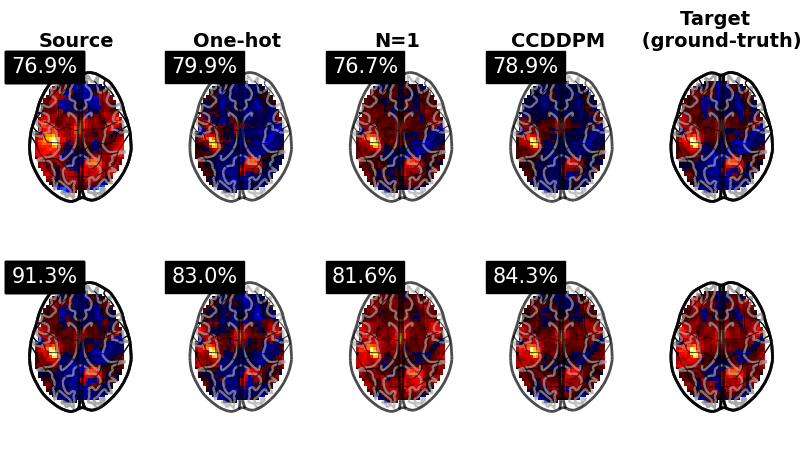

In [17]:
config = {
    'model':['c_ddpm','cc_ddpm', 'cc_ddpm'], 
    'n' : ['', '_n1',  '_n10'],
    'sampling' : ['', '', '-kmeans']
}

titles = [['Source', 'One-hot', 'N=1', 'CCDDPM', 'Target \n (ground-truth)'], 
          ['','','','','']]

transfer = [
    (2,1),
    (1,0),
]


f,ax = plt.subplots(2,5, figsize=(10, 5))

for t_idx, t in enumerate(transfer):
    for i in range(len(config['model'])):
        printer = ''
        printer_orig = ''
            
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]

        if model not in ['stargan', 'vox2vox', 'cycleGAN']:
            sample_dir = f'./results/samples/{model}-samples{sampling}'
    
            p_source_list = np.unique(
                [f.split('_')[-2][0:1] for f in sorted(
                    glob(
                        f'{sample_dir}/src-image_*-dataset_rh_4classes-jeanzay_ep*_w0.5*-orig_*-target_*.nii.gz'
                    )
                )
                ]
            )
            p_target_list = np.unique(
                [f.split('_')[-1][0:-7] for f in sorted(
                    glob(
                        f'{sample_dir}/trg-image_*-dataset_rh_4classes-jeanzay_ep*_w0.5*-orig_*-target_*.nii.gz'
                    )
                )
                ]
            )

            gen_img_list = glob(
                    f'{sample_dir}/gen-image_{t[0]+8}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_{p_source_list[t[0]]}-target_{p_target_list[t[1]]}.nii.gz')
            src_img_list = glob(
                    f'{sample_dir}/src-image_{t[0]+8}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_{p_source_list[t[0]]}-target_{p_target_list[t[1]]}.nii.gz')
            trg_img_list = glob(
                    f'{sample_dir}/trg-image_{t[0]+8}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_{p_source_list[t[0]]}-target_{p_target_list[t[1]]}.nii.gz')
            
        elif model == 'stargan':
            sample_dir = f'./results/samples/{model}-samples{sampling}'
            
            gen_img_list = glob(
                    f'{sample_dir}/gen_img-{t[0]+8}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz')
            src_img_list = glob(
                    f'{sample_dir}/src_img-{t[0]+8}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz')
            trg_img_list = glob(
                    f'{sample_dir}/trg_img-{t[0]+8}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz')

        else: 
            if model == 'vox2vox':
                sample_dir = f'/Users/egermani/Documents/pipeline_transition/figures/{pipelines[t[0]]}_to_{pipelines[t[1]]}_b-16_lr-0.0001_e-199_model-{model}_l-mse'
            elif model == 'cycleGAN':
                sample_dir = f'/Users/egermani/Documents/pipeline_transition/figures/{pipelines[t[0]]}_to_{pipelines[t[1]]}_b-16_lr-0.0001_e-190_model-{model}'

            gen_img_list = glob(
                    f'{sample_dir}/gen-image-{t[0]}_src-{pipelines[t[0]]}_trg-{pipelines[t[1]]}.nii.gz')
            src_img_list = glob(
                    f'{sample_dir}/src-image-{t[0]}_src-{pipelines[t[0]]}_trg-{pipelines[t[1]]}.nii.gz')
            trg_img_list = glob(
                    f'{sample_dir}/trg-image-{t[0]}_src-{pipelines[t[0]]}_trg-{pipelines[t[1]]}.nii.gz')
        
         # Initial 
        display = plotting.plot_glass_brain(
            src_img_list[0],
            colorbar=False,
            cmap=nilearn_cmaps['cold_hot'], 
            annotate=False,
            plot_abs=False, 
            title = str(round(metrics.get_correlation(nib.load(src_img_list[0]), nib.load(trg_img_list[0]))*100,1)) + '%',
            display_mode='z',
            vmin=-1,
            vmax=1, 
            threshold=0,
            figure=f, 
            axes=ax[t_idx, 0]
        )

        ax[t_idx, 0].set_title(titles[t_idx][0], fontsize=14, fontweight='bold')
        
        # Ground truth
        display = plotting.plot_glass_brain(
            trg_img_list[0],
            cmap=nilearn_cmaps['cold_hot'], annotate=False,
            plot_abs=False, #title = titles[t_idx][1],
            display_mode='z', vmin=-1, vmax=1,threshold=0,
            figure=f, axes=ax[t_idx, -1]
        )

        ax[t_idx, 1].set_title(titles[t_idx][1], fontsize=14, fontweight='bold')
        
        # QC
        display = plotting.plot_glass_brain(
            mask(trg_img_list[0], gen_img_list[0]),
            cmap=nilearn_cmaps['cold_hot'], 
            annotate=False,
            plot_abs=False, 
            title =str(round(metrics.get_correlation(nib.load(gen_img_list[0]), nib.load(trg_img_list[0]))*100,1)) + '%', 
            display_mode='z', 
            vmin=-1, 
            vmax=1,
            threshold=0,
            figure=f, 
            axes=ax[t_idx, i+1],
        )
        # if i==0:
        #     print('S_T', metrics.get_correlation(nib.load(src_img_list[0]), nib.load(trg_img_list[0])))
        # print(model, metrics.get_correlation(nib.load(trg_img_list[0]),  nib.load(gen_img_list[0])))

        ax[t_idx, i+2].set_title(titles[t_idx][i+2], fontsize=14, fontweight='bold')

plt.savefig('./results/figures/figure-ddpm.png')

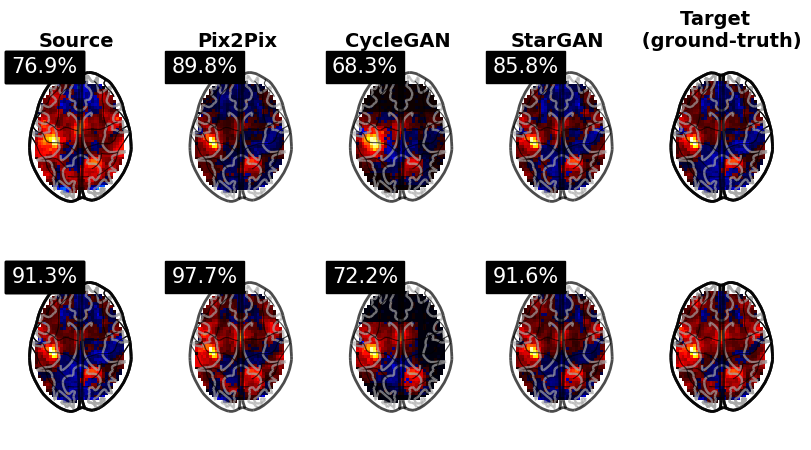

In [19]:
config = {
    'model':['vox2vox','cycleGAN', 'stargan'], 
    'n' : ['', '',  ''],
    'sampling' : ['', '', '']
}

titles = [['Source', 'Pix2Pix', 'CycleGAN', 'StarGAN', 'Target \n (ground-truth)'], 
          ['','','','','']]

transfer = [
    (2,1),
    (1,0),
]


f,ax = plt.subplots(2,5, figsize=(10, 5))

for t_idx, t in enumerate(transfer):
    for i in range(len(config['model'])):
        printer = ''
        printer_orig = ''
            
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]

        if model not in ['stargan', 'vox2vox', 'cycleGAN']:
            sample_dir = f'./results/samples/{model}-samples{sampling}'
    
            p_source_list = np.unique(
                [f.split('_')[-2][0:1] for f in sorted(
                    glob(
                        f'{sample_dir}/src-image_*-dataset_rh_4classes-jeanzay_ep*_w0.5*-orig_*-target_*.nii.gz'
                    )
                )
                ]
            )
            p_target_list = np.unique(
                [f.split('_')[-1][0:-7] for f in sorted(
                    glob(
                        f'{sample_dir}/trg-image_*-dataset_rh_4classes-jeanzay_ep*_w0.5*-orig_*-target_*.nii.gz'
                    )
                )
                ]
            )

            gen_img_list = glob(
                    f'{sample_dir}/gen-image_{t[0]+8}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_{p_source_list[t[0]]}-target_{p_target_list[t[1]]}.nii.gz')
            src_img_list = glob(
                    f'{sample_dir}/src-image_{t[0]+8}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_{p_source_list[t[0]]}-target_{p_target_list[t[1]]}.nii.gz')
            trg_img_list = glob(
                    f'{sample_dir}/trg-image_{t[0]+8}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_{p_source_list[t[0]]}-target_{p_target_list[t[1]]}.nii.gz')
            
        elif model == 'stargan':
            sample_dir = f'./results/samples/{model}-samples{sampling}'
            
            gen_img_list = glob(
                    f'{sample_dir}/gen_img-{t[0]+8}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz')
            src_img_list = glob(
                    f'{sample_dir}/src_img-{t[0]+8}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz')
            trg_img_list = glob(
                    f'{sample_dir}/trg_img-{t[0]+8}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz')

        else: 
            if model == 'vox2vox':
                sample_dir = f'/Users/egermani/Documents/pipeline_transition/figures/{pipelines[t[0]]}_to_{pipelines[t[1]]}_b-16_lr-0.0001_e-199_model-{model}_l-mse'
            elif model == 'cycleGAN':
                sample_dir = f'/Users/egermani/Documents/pipeline_transition/figures/{pipelines[t[0]]}_to_{pipelines[t[1]]}_b-16_lr-0.0001_e-190_model-{model}'

            gen_img_list = glob(
                    f'{sample_dir}/gen-image-{t[0]}_src-{pipelines[t[0]]}_trg-{pipelines[t[1]]}.nii.gz')
            src_img_list = glob(
                    f'{sample_dir}/src-image-{t[0]}_src-{pipelines[t[0]]}_trg-{pipelines[t[1]]}.nii.gz')
            trg_img_list = glob(
                    f'{sample_dir}/trg-image-{t[0]}_src-{pipelines[t[0]]}_trg-{pipelines[t[1]]}.nii.gz')
        
         # Initial 
        display = plotting.plot_glass_brain(
            src_img_list[0],
            colorbar=False,
            cmap=nilearn_cmaps['cold_hot'], 
            annotate=False,
            plot_abs=False, 
            title = str(round(metrics.get_correlation(nib.load(src_img_list[0]), nib.load(trg_img_list[0]))*100,1)) + '%',
            display_mode='z',
            vmin=-1,
            vmax=1, 
            threshold=0,
            figure=f, 
            axes=ax[t_idx, 0]
        )

        ax[t_idx, 0].set_title(titles[t_idx][0], fontsize=14, fontweight='bold')
        
        # Ground truth
        display = plotting.plot_glass_brain(
            trg_img_list[0],
            cmap=nilearn_cmaps['cold_hot'], annotate=False,
            plot_abs=False, #title = titles[t_idx][1],
            display_mode='z', vmin=-1, vmax=1,threshold=0,
            figure=f, axes=ax[t_idx, -1]
        )

        ax[t_idx, 1].set_title(titles[t_idx][1], fontsize=14, fontweight='bold')
        
        # QC
        display = plotting.plot_glass_brain(
            mask(trg_img_list[0], gen_img_list[0]),
            cmap=nilearn_cmaps['cold_hot'], 
            annotate=False,
            plot_abs=False, 
            title =str(round(metrics.get_correlation(nib.load(gen_img_list[0]), nib.load(trg_img_list[0]))*100,1)) + '%', 
            display_mode='z', 
            vmin=-1, 
            vmax=1,
            threshold=0,
            figure=f, 
            axes=ax[t_idx, i+1],
        )
        # if i==0:
        #     print('S_T', metrics.get_correlation(nib.load(src_img_list[0]), nib.load(trg_img_list[0])))
        # print(model, metrics.get_correlation(nib.load(trg_img_list[0]),  nib.load(gen_img_list[0])))

        ax[t_idx, i+2].set_title(titles[t_idx][i+2], fontsize=14, fontweight='bold')

plt.savefig('./results/figures/figure-gans.png')

## Supplementary figures

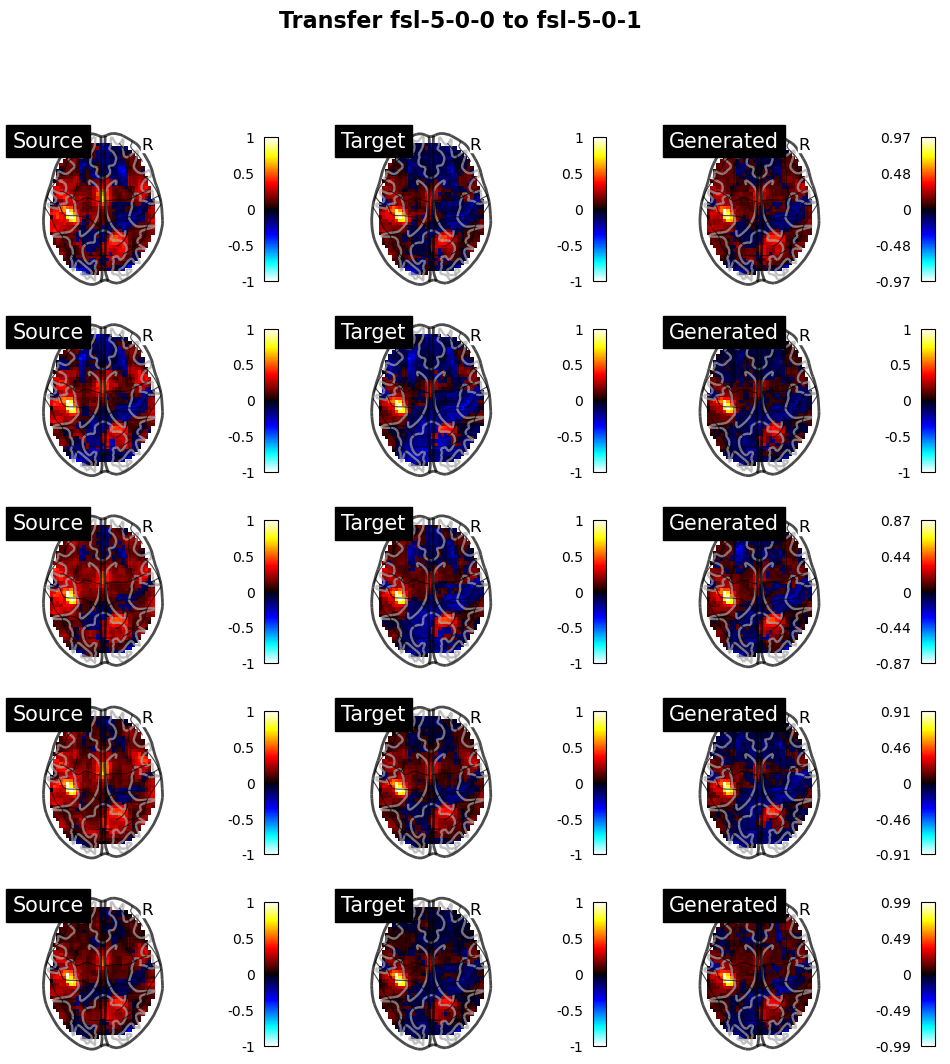

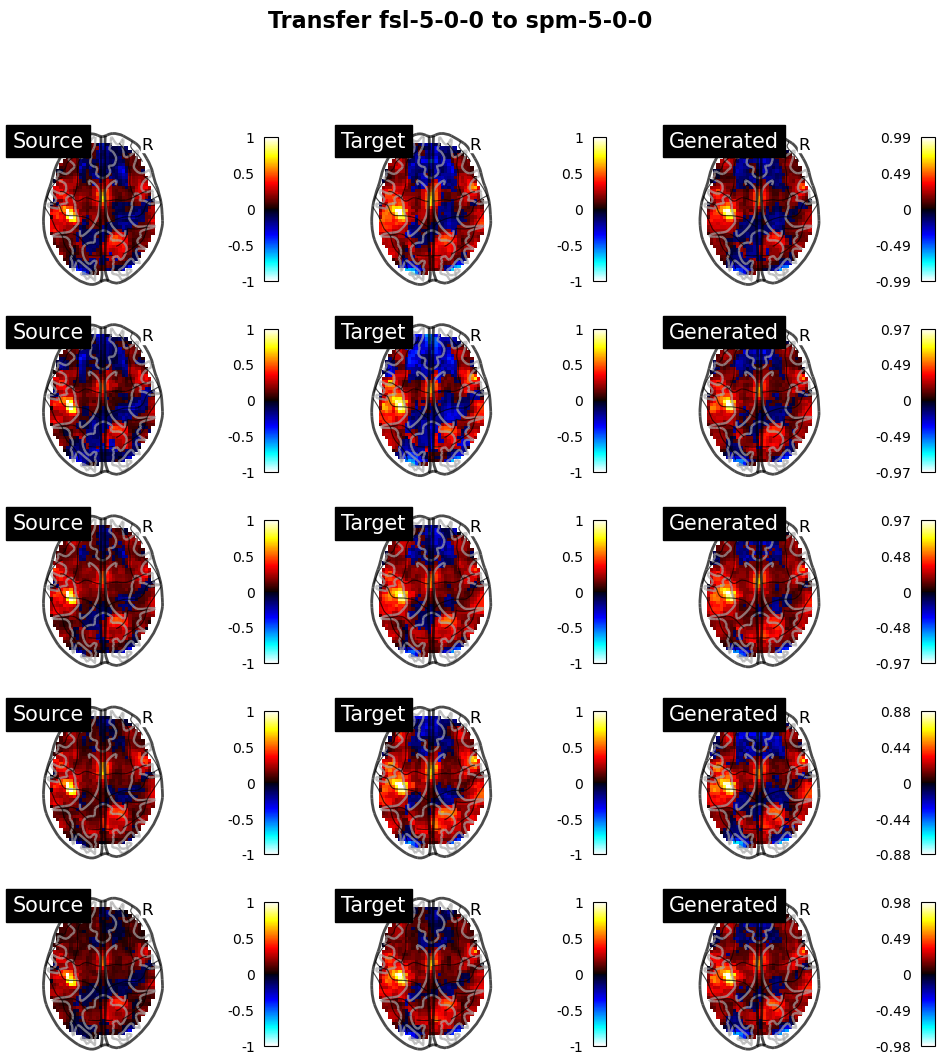

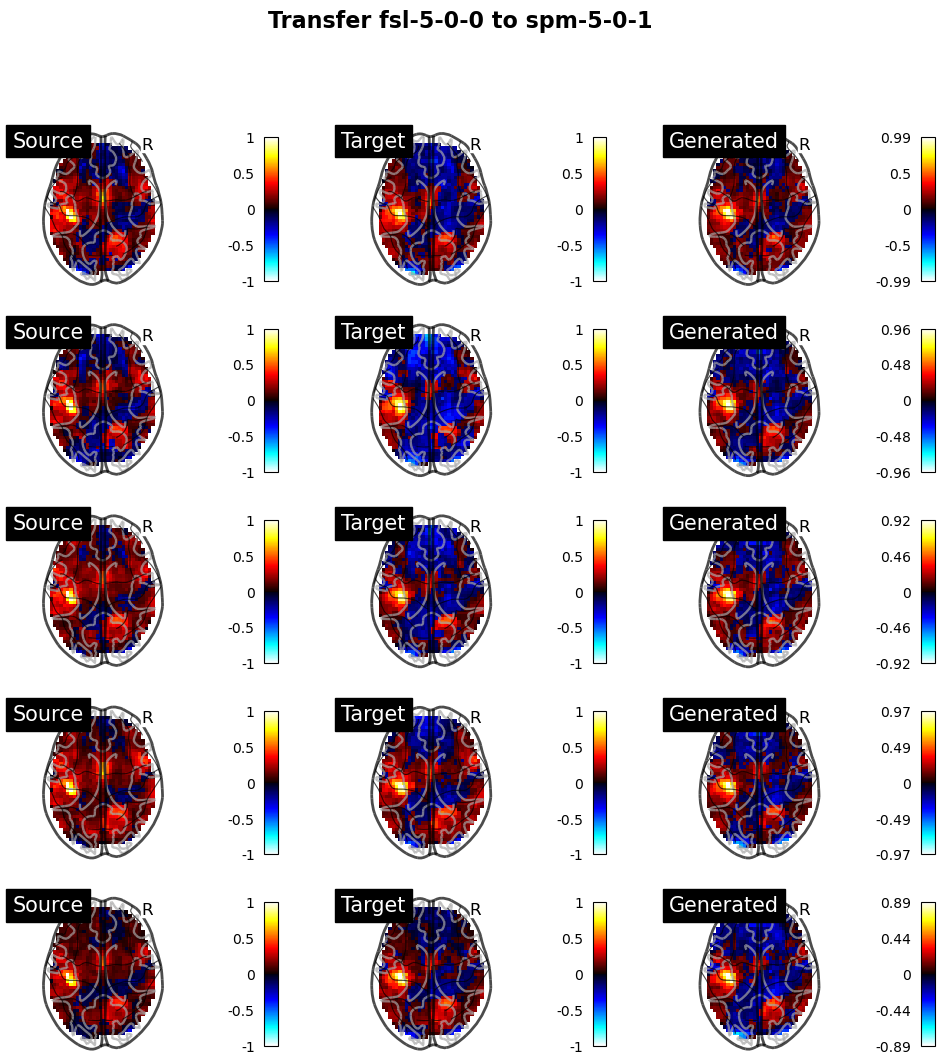

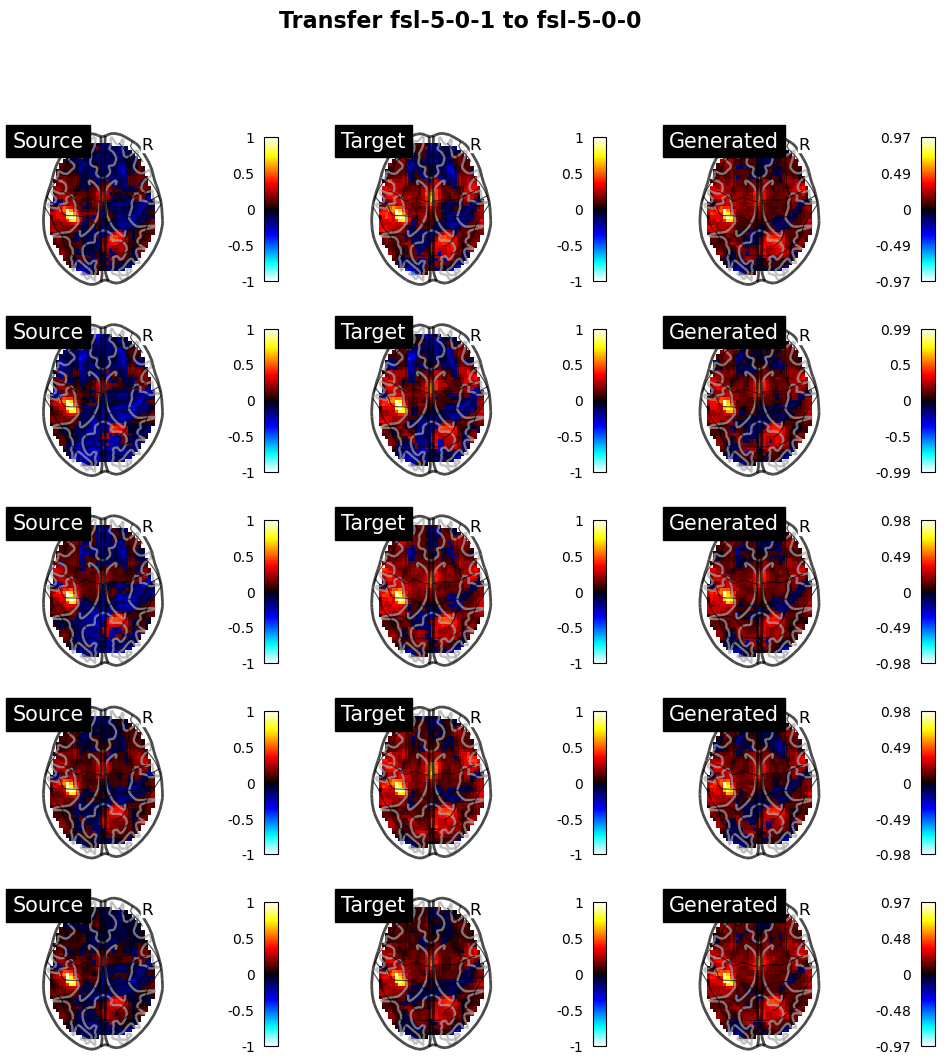

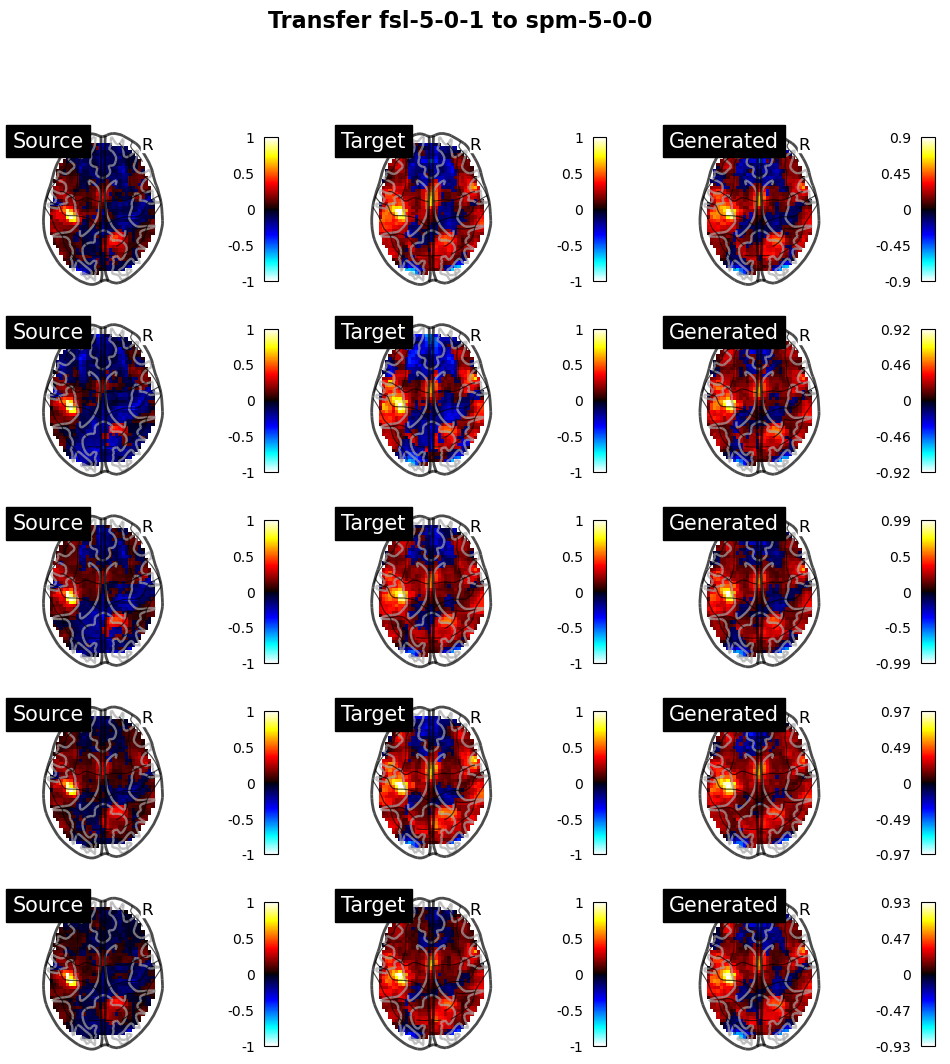

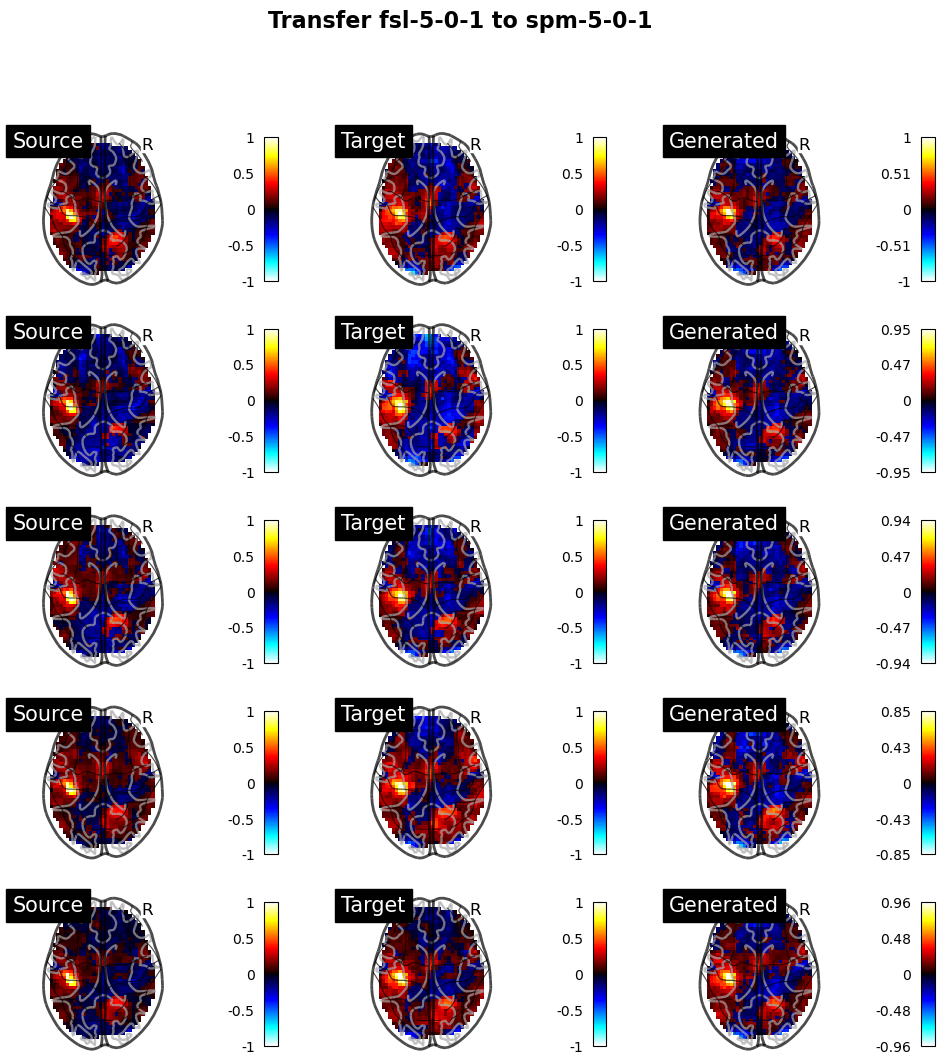

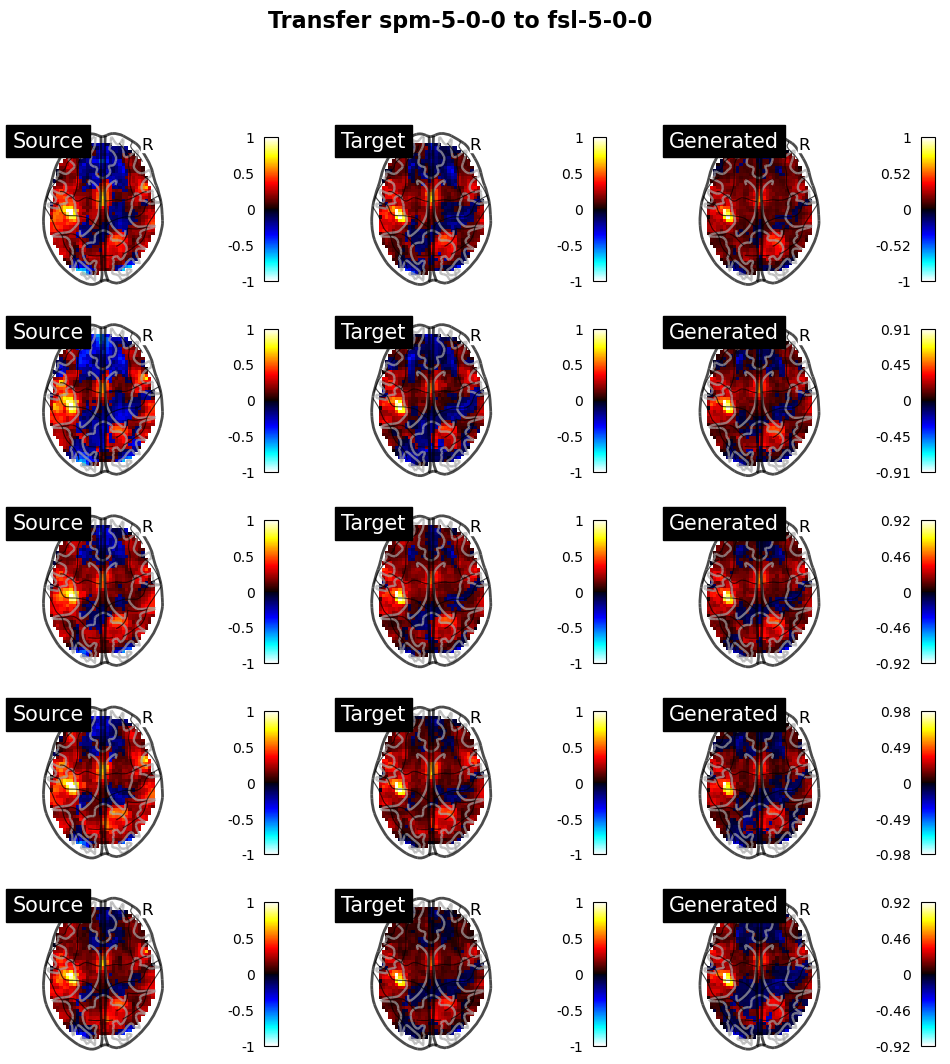

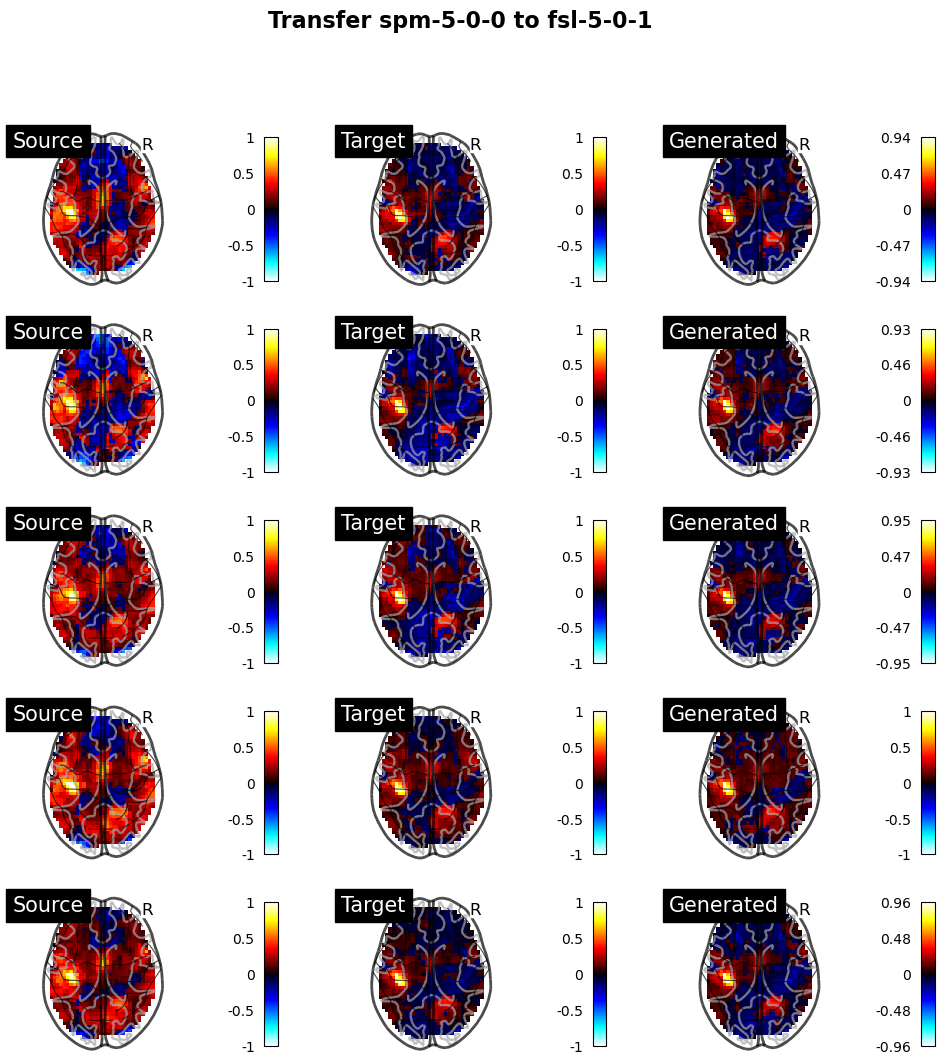

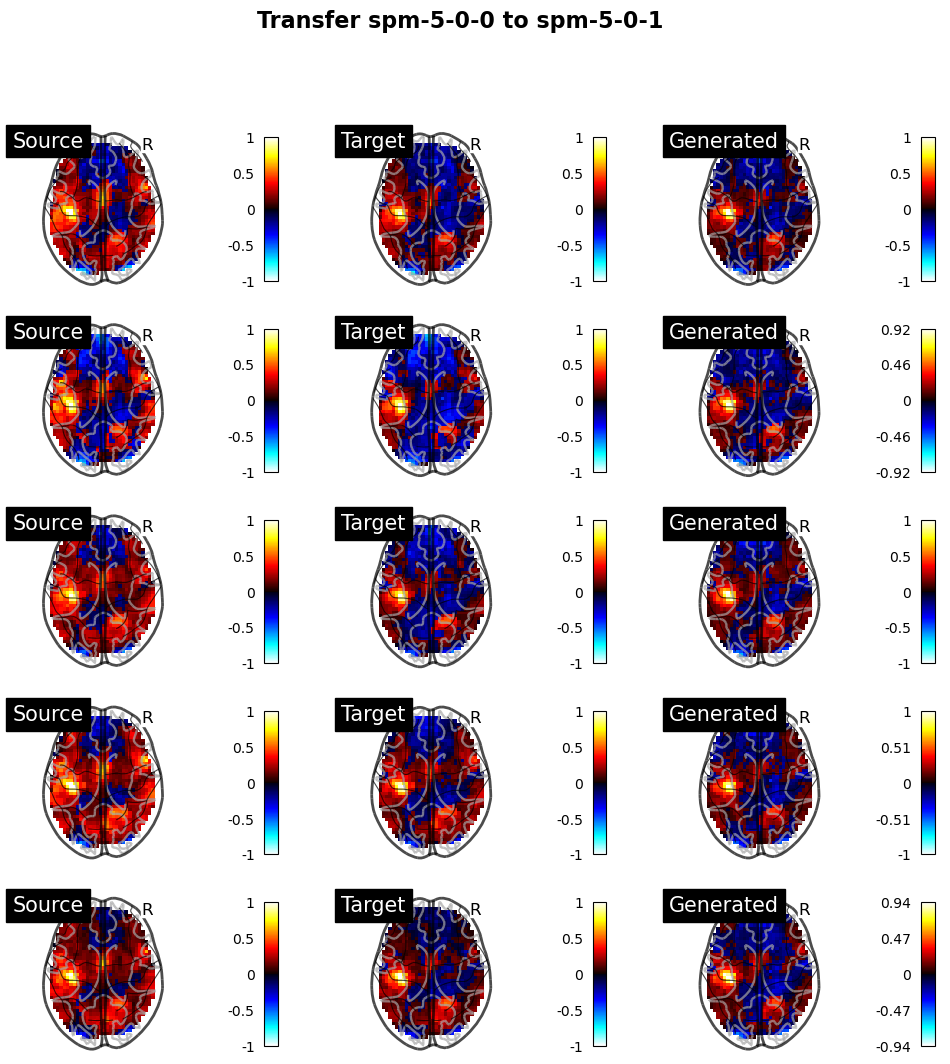

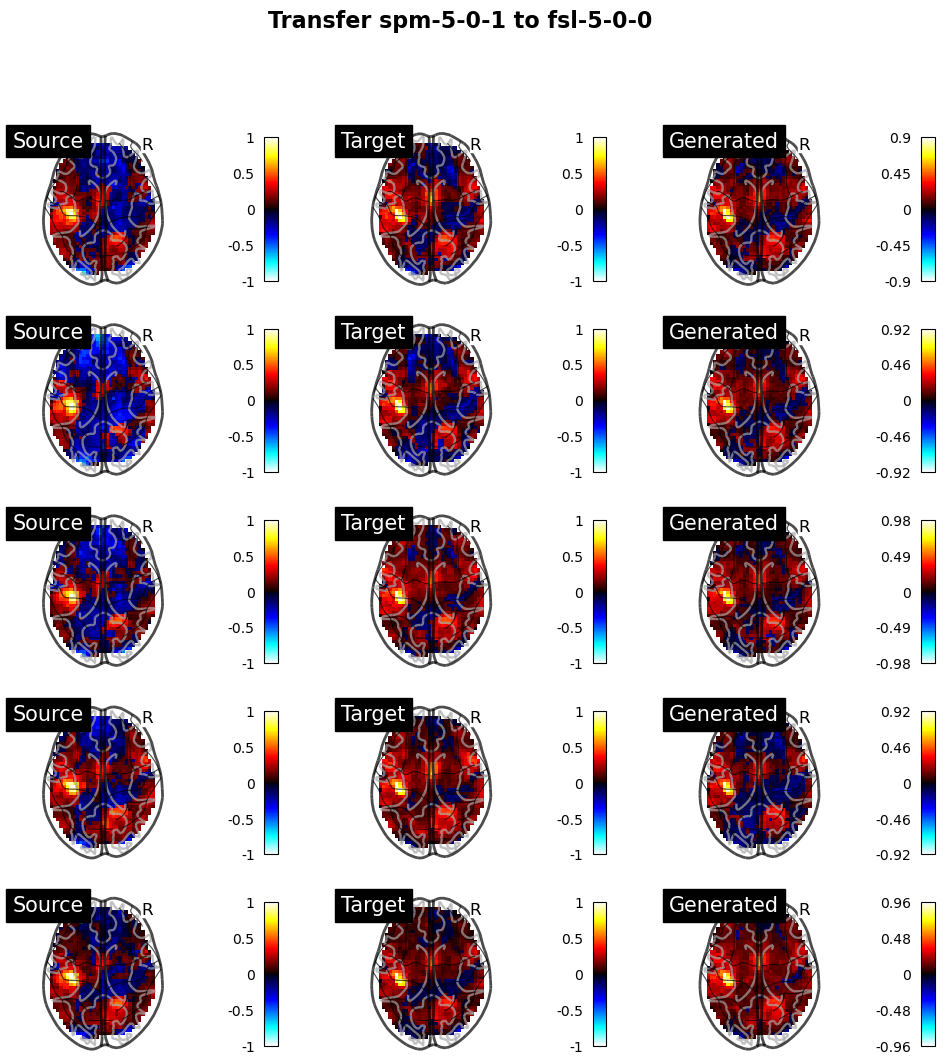

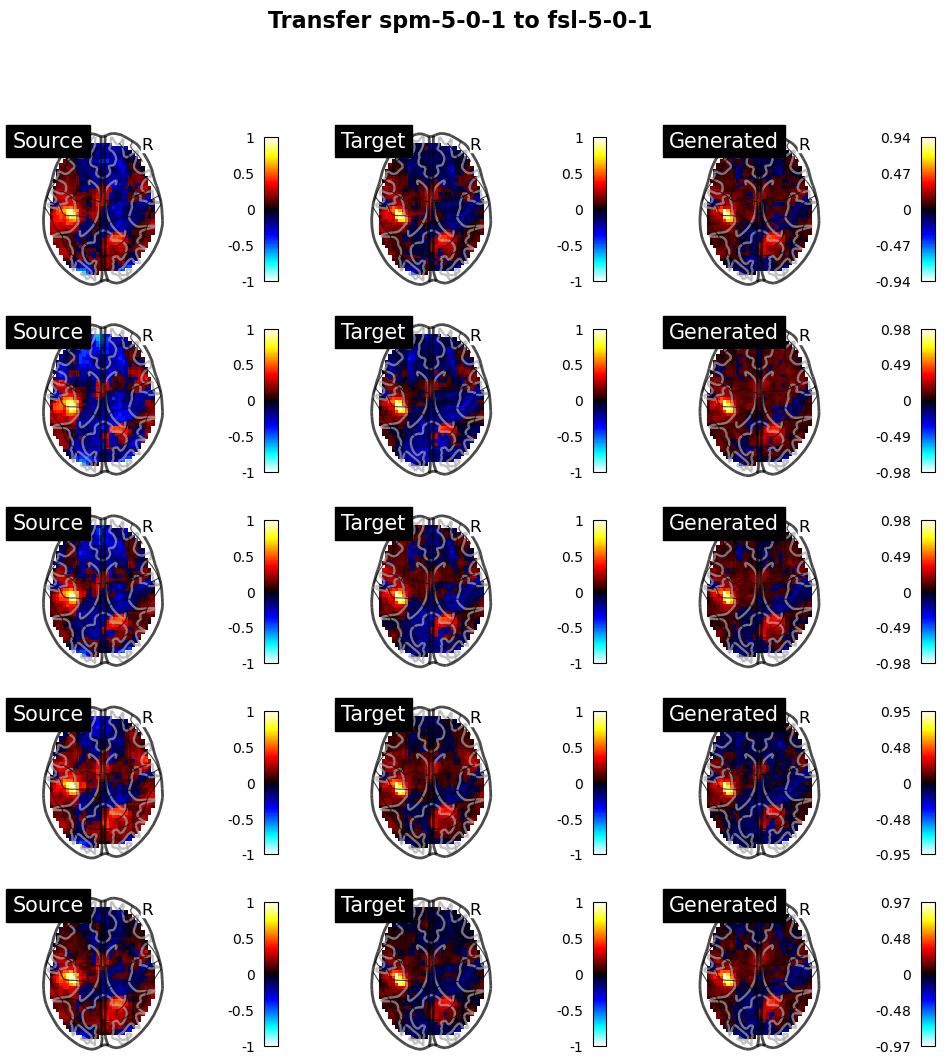

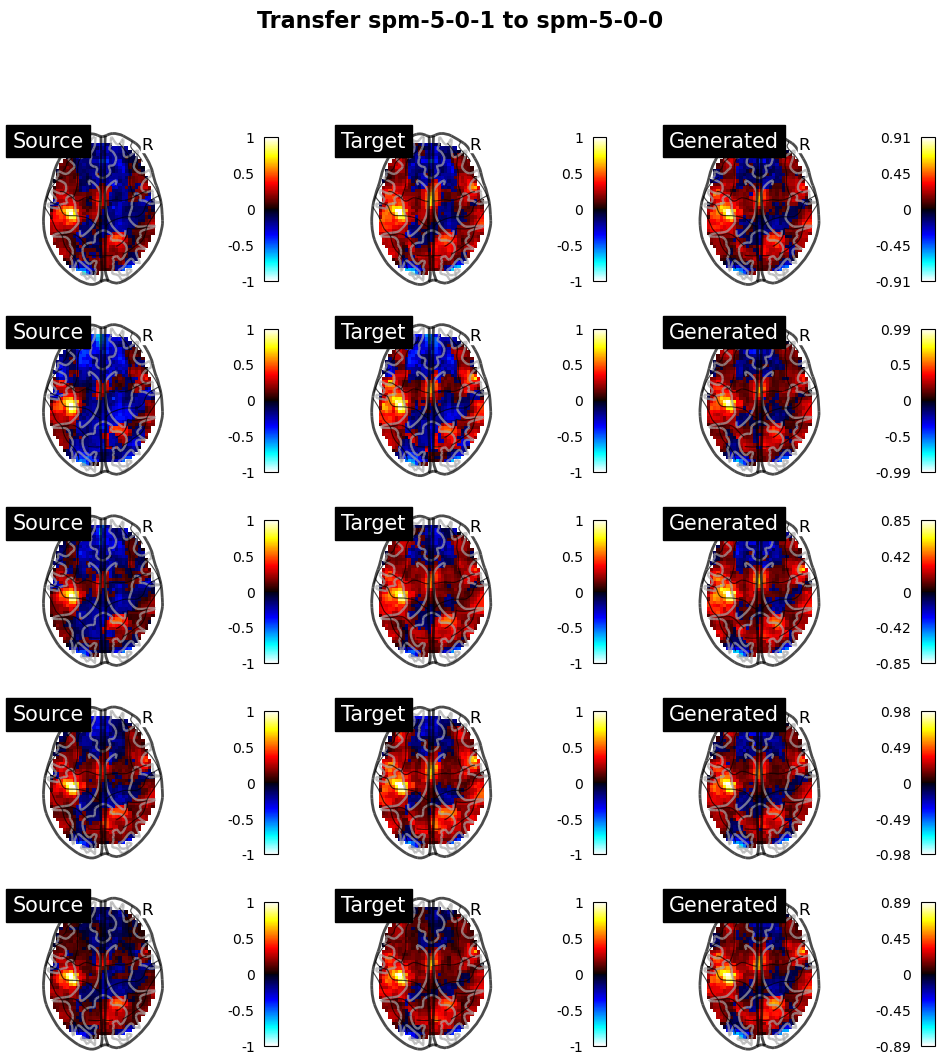

In [18]:
config = {
    'model':['cc_ddpm'], 
    'n' : ['_n10'],
    'sampling' : ['-kmeans']
}

transfer = [(i,j) for i in range(4) for j in range(4) if i!=j]

for t_idx, t in enumerate(transfer):
    f,ax = plt.subplots(5,3, figsize=(12, 12))
    for j in range(5):
        for i in range(len(config['model'])):
            printer = ''
            printer_orig = ''
                
            n = config['n'][i]
            sampling = config['sampling'][i]
            model = config['model'][i]
        
            sample_dir = f'./results/samples/{model}-samples{sampling}'
        
            p_source_list = np.unique(
                [f.split('_')[-2][0:1] for f in sorted(
                    glob(
                        f'{sample_dir}/src-image_*-dataset_rh_4classes-jeanzay_ep*_w0.5*-orig_*-target_*.nii.gz'
                    )
                )
                ]
            )
            p_target_list = np.unique(
                [f.split('_')[-1][0:-7] for f in sorted(
                    glob(
                        f'{sample_dir}/trg-image_*-dataset_rh_4classes-jeanzay_ep*_w0.5*-orig_*-target_*.nii.gz'
                    )
                )
                ]
            )

        
            gen_img_list = glob(
                    f'{sample_dir}/gen-image_{t[0]+j*4}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_{p_source_list[t[0]]}-target_{p_target_list[t[1]]}.nii.gz')
            src_img_list = glob(
                    f'{sample_dir}/src-image_{t[0]+j*4}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_{p_source_list[t[0]]}-target_{p_target_list[t[1]]}.nii.gz')
            trg_img_list = glob(
                    f'{sample_dir}/trg-image_{t[0]+j*4}-dataset_rh_4classes-jeanzay_ep*_w0.5{n}-orig_{p_source_list[t[0]]}-target_{p_target_list[t[1]]}.nii.gz')
    
             # Initial 
            display = plotting.plot_glass_brain(
                src_img_list[0],
                colorbar=True,
                cmap=nilearn_cmaps['cold_hot'],
                plot_abs=False,
                display_mode='z',
                figure=f, axes=ax[j, 0], title='Source',
            )
            
            # Ground truth
            display = plotting.plot_glass_brain(
                trg_img_list[0],
                colorbar=True,
                cmap=nilearn_cmaps['cold_hot'],
                plot_abs=False,
                display_mode='z',
                figure=f, axes=ax[j, 1], title='Target',
            )
            # QC
            display = plotting.plot_glass_brain(
                mask(trg_img_list[0], gen_img_list[0]),
                colorbar=True,
                cmap=nilearn_cmaps['cold_hot'],
                plot_abs=False,
                display_mode='z',
                figure=f, axes=ax[j, i+2], title='Generated'
            )

    f.suptitle(f'Transfer {pipelines[t[0]]} to {pipelines[t[1]]}', fontsize=16, fontweight='bold')
    plt.savefig(f'./results/supp-figure_transfer-{pipelines[t[0]]}_{pipelines[t[1]]}.png')

In [21]:
from PIL import Image

# Create the frames
frames = []
imgs = glob("./results/supp-figure_transfer*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('./results/transfers.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1000, loop=0)

#### Supplementary Table 1

In [22]:
df_correlations = pd.read_csv('./results/metrics/classifier-correlations.csv')

In [43]:
for transfer in np.unique(df_correlations['Transfer']):
    printer = str(transfer)
    for layer in range(1, 5):
        corr = round(df_correlations['Correlation'].loc[
        (df_correlations['Transfer']==transfer) & (df_correlations['Layer']==layer)
        ].tolist()[0] * 100, 1)

        printer += ' & ' 
        printer += str(corr)
    printer += ' //'
        
    print(printer)  

fsl-5-0-0_fsl-5-0-0 & 100.0 & 100.0 & 100.0 & 100.0 //
fsl-5-0-0_fsl-5-0-1 & 86.5 & 91.4 & 95.4 & 99.2 //
fsl-5-0-0_spm-5-0-0 & 88.8 & 88.2 & 93.6 & 98.2 //
fsl-5-0-0_spm-5-0-1 & 74.5 & 81.0 & 88.7 & 97.1 //
fsl-5-0-1_fsl-5-0-0 & 86.5 & 91.4 & 95.4 & 99.2 //
fsl-5-0-1_fsl-5-0-1 & 100.0 & 100.0 & 100.0 & 100.0 //
fsl-5-0-1_spm-5-0-0 & 74.8 & 77.7 & 88.2 & 97.3 //
fsl-5-0-1_spm-5-0-1 & 84.8 & 85.8 & 92.4 & 98.0 //
spm-5-0-0_fsl-5-0-0 & 88.8 & 88.2 & 93.6 & 98.2 //
spm-5-0-0_fsl-5-0-1 & 74.8 & 77.7 & 88.2 & 97.3 //
spm-5-0-0_spm-5-0-0 & 100.0 & 100.0 & 100.0 & 100.0 //
spm-5-0-0_spm-5-0-1 & 86.5 & 90.9 & 94.2 & 98.4 //
spm-5-0-1_fsl-5-0-0 & 74.5 & 81.0 & 88.7 & 97.1 //
spm-5-0-1_fsl-5-0-1 & 84.8 & 85.8 & 92.4 & 98.0 //
spm-5-0-1_spm-5-0-0 & 86.5 & 90.9 & 94.2 & 98.4 //
spm-5-0-1_spm-5-0-1 & 100.0 & 100.0 & 100.0 & 100.0 //


#### Supplementary Table 2

In [11]:
import pandas as pd
import numpy as np

In [ ]:
df_groups = pd.read_csv('../hcp_pipelines/data/derived/group_analysis/groups_n_50.csv',
                       header = None)
n = []
for i in range(1000):
    for j in range(1000):
        if i < j: 
            l1 = df_groups.iloc[i]
            l2 = df_groups.iloc[j]
            n.append(len(list(set(l1) & set(l2))))

In [13]:
print('Mean nº of participants in common between groups:', np.mean(n), '+/-', np.std(n))
print('Max nº of participants in common between groups:', np.max(n))
print('Min nº of participants in common between groups:', np.min(n))

Mean nº of participants in common between groups: 2.3161361361361363 +/- 1.4541996362492848
Max nº of participants in common between groups: 12
Min nº of participants in common between groups: 0


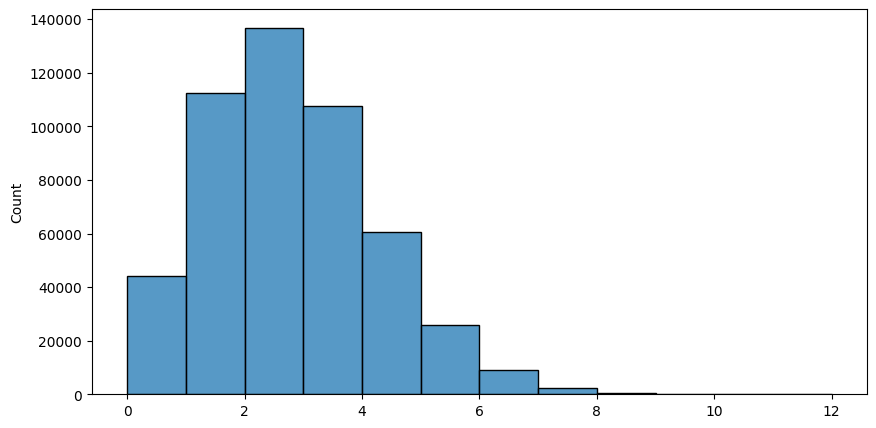

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns 
f,ax = plt.subplots(1,1, figsize=(10,5))
g =sns.histplot(x=n, binwidth=1, figure=f, axes=ax)
f.suptitle = 'N. of common participants between pairs of groups'

In [5]:
for img in glob('/Users/egermani/Documents/pipeline_transition/figures/*/*.nii.gz'):
    if len(nib.load(img).shape)==5:
        data = nib.load(img).get_fdata()[0,0,:,:,:]
    else:
        pass
    img_bis = nib.Nifti1Image(data, nib.load(img).affine)
    nib.save(img_bis, img)

#### Supplementary Table : out of distribution

In [71]:
config = {
    'model':['stargan'], 
    'n' : [''],
    'sampling' : ['']
}

transfer = [
    (1,2),
    (2,1),
    (1,3),
    (1,0),
]

for i in range(len(config['model'])):
    printer_init = ''
    printer = ''
    for t_idx, t in enumerate(transfer):
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]

        if model == 'stargan':
            corr_df = f'./results/metrics/correlations_{pipelines[transfer[t_idx][0]]}_{pipelines[transfer[t_idx][1]]}_w0.5-{model}-outsample.csv'
            df = pd.read_csv(corr_df)
            corr = df['Correlation'].loc[df['Type']=='Target-Generated'].tolist()
            corr_init = df['Correlation'].loc[df['Type']=='Source-Target'].tolist()

        printer_init += str(round(np.mean(corr_init)*100,1)) + ' & '
        printer += str(round(np.mean(corr)*100,1)) + ' & '

    print(printer_init)
    print(printer)

86.5 & 86.5 & 85.7 & 96.2 & 
71.5 & 71.5 & 63.4 & 82.6 & 
